# **Diabetes Prediction**

## **Dataset Loading**

In [83]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

Data Collection: PIMA Diabetes dataset

In [84]:
df = pd.read_csv('diabetes.csv')

In [85]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [86]:
df.shape

(768, 9)

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [88]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [89]:
df['Outcome'].value_counts()

,count
Outcome,
0,500
1,268


In [90]:
df['Outcome'].value_counts(normalize=True) * 100

,proportion
Outcome,
0,65.104167
1,34.895833


good point to group datasets based on their labels

In [91]:
df.groupby('Outcome').mean()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,3.298000,109.980000,68.184000,19.664000,68.792000,30.304200,0.429734,31.190000
1,4.865672,141.257463,70.824627,22.164179,100.335821,35.142537,0.550500,37.067164


## **Data Cleaning & Preprocessing**

In [92]:
df.duplicated().sum()

np.int64(0)

Handling Null values

In [93]:
df.isnull().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


In [94]:
# Count how many zeros in each column
(df == 0).sum()


,0
Pregnancies,111
Glucose,5
BloodPressure,35
SkinThickness,227
Insulin,374
BMI,11
DiabetesPedigreeFunction,0
Age,0
Outcome,500


In [95]:
cols_with_missing = ['Glucose', 'BloodPressure', 'SkinThickness','Insulin', 'BMI' ]
df[cols_with_missing] = df[cols_with_missing].replace(0, np.nan)

In [96]:
(df==0).sum()

,0
Pregnancies,111
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,500


**Imputing NaN values:**

General Rules for Choosing Mean vs. Median:

Mean imputation:

- Good if the feature is normally distributed (symmetric, bell-shaped).
Sensitive to outliers (e.g., a few very large insulin values will pull the mean upward).

Median imputation:
- Good if the feature is skewed or has outliers.
More robust in medical data (since health metrics often have skew).

In medical datasets (like glucose, insulin, skin thickness, BMI), distributions are usually skewed, so median is safer.

We can check the distribution of each column with a histogram:

**What should be the figsize?**

If you plot only the 5 columns with missing values → (12,8) is perfect.

If you plot all features at once using df.hist() → (20,20) works better.

**Effect of Different Bins:**

Example for Glucose column:
- bins=10 → histogram looks blocky, hides detail.
- bins=30 → smoother view, enough detail to see skewness.
- bins=100 → too detailed, lots of empty bars (especially with small datasets).

**How to Choose the Right Number of Bins**

There are some statistical rules:

- Sturges’ Rule:

bins = log2(n) + 1

For 768 rows → ≈ 10 bins.

- Square-root Rule:

bins = sqrt(n)

For 768 rows → ≈ 28 bins (close to 30).

- Freedman Diaconis Rule:

Based on data spread (IQR) and sample size, often gives 20–40 bins.

That’s why 30 is a practical choice — it’s close to what theory suggests for medium datasets.

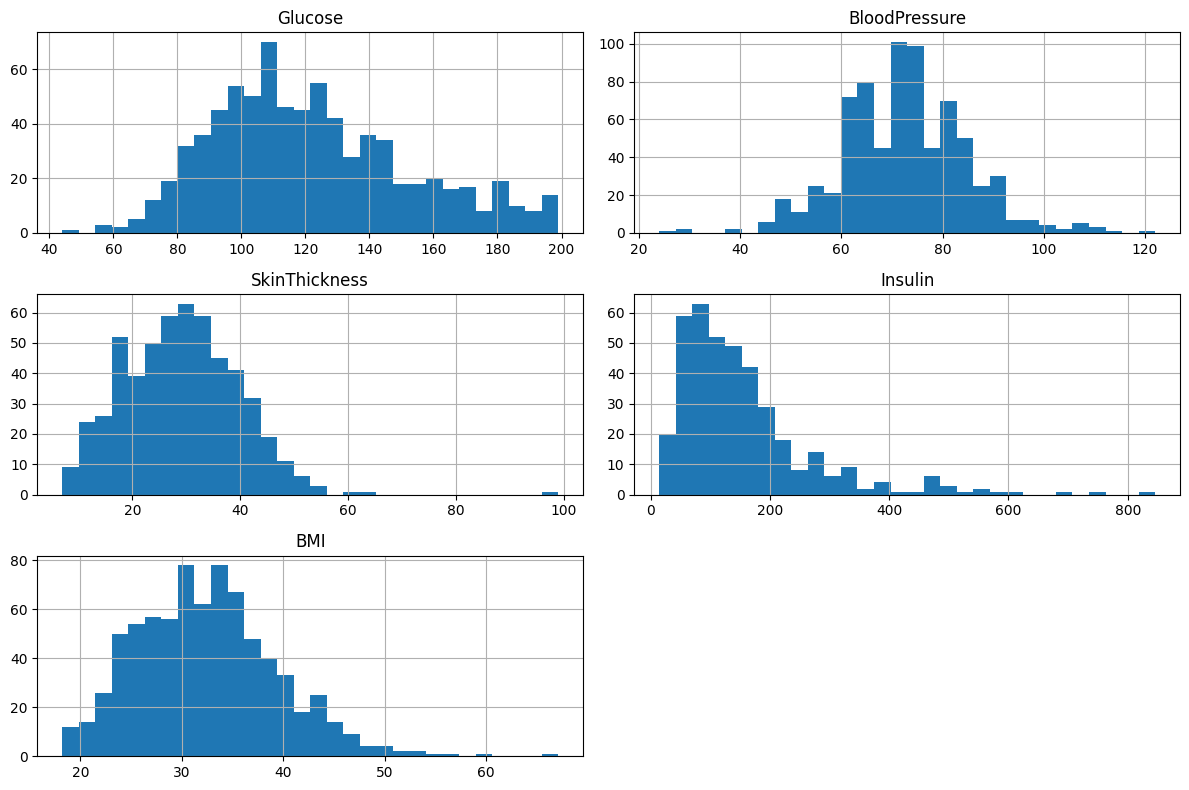

In [97]:
import matplotlib.pyplot as plt

df[cols_with_missing].hist(bins = 30, figsize=(12,8))
plt.tight_layout()
plt.show()

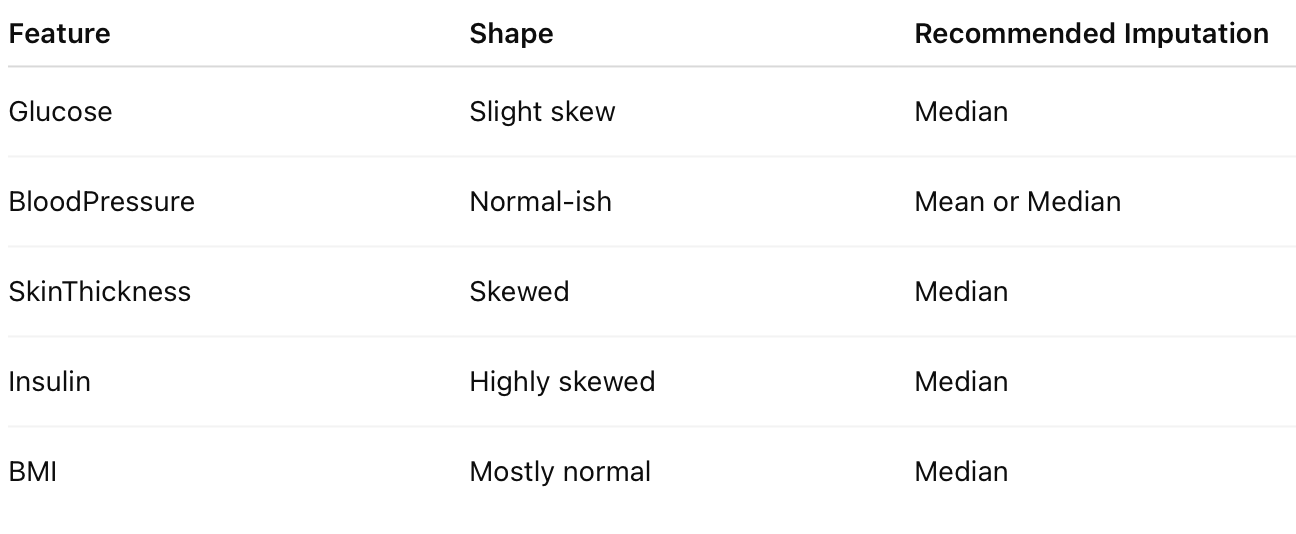

In [98]:
df['Glucose'] = df['Glucose'].fillna(df['Glucose'].mean())
df['BloodPressure'] = df['BloodPressure'].fillna(df['BloodPressure'].mean())
df['SkinThickness'] = df['SkinThickness'].fillna(df['SkinThickness'].median())
df['Insulin'] = df['Insulin'].fillna(df['Insulin'].median())
df['BMI'] = df['BMI'].fillna(df['BMI'].median())

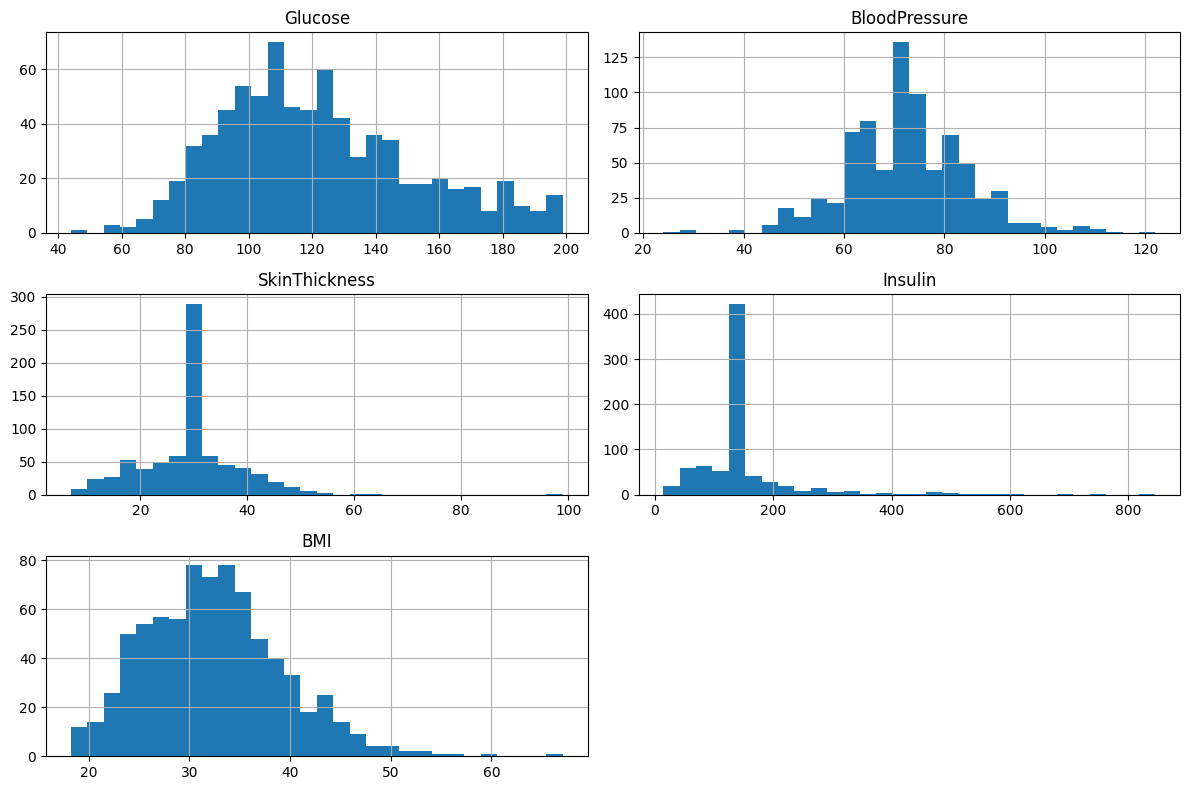

In [99]:
df[cols_with_missing].hist(bins = 30, figsize=(12,8))
plt.tight_layout()
plt.show()

## **Train-Test Split (with stratification)**

In [100]:
X = df.drop('Outcome', axis = 1)
y = df['Outcome']

Stratified split preserves the class ratio (important for imbalanced data)

In [101]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.20, random_state = 42, stratify = y
)

In [102]:
print("Shapes: X_train:", X_train.shape, "| X_test:", X_test.shape)
print("\nClass ratio: overall vs splits:")

print(f"Overall: {y.mean()*100:.2f}%")
print(f"Train  : {y_train.mean()*100:.2f}%")
print(f"Test   : {y_test.mean()*100:.2f}%")

Shapes: X_train: (614, 8) | X_test: (154, 8)

Class ratio: overall vs splits:
Overall: 34.90%
Train  : 34.85%
Test   : 35.06%


## **Feature Scaling**

In [103]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [104]:
X_train.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
353,1,90.0,62.0,12.0,43.0,27.2,0.580,24
711,5,126.0,78.0,27.0,22.0,29.6,0.439,40
373,2,105.0,58.0,40.0,94.0,34.9,0.225,25
46,1,146.0,56.0,29.0,125.0,29.7,0.564,29
682,0,95.0,64.0,39.0,105.0,44.6,0.366,22


In [105]:
print("Before scaling (first 5 rows):")
print(X_train.head())

print("\nAfter scaling (first 5 rows):")
print(X_train_scaled[:5])

Before scaling (first 5 rows):
     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
353            1     90.0           62.0           12.0     43.0  27.2   
711            5    126.0           78.0           27.0     22.0  29.6   
373            2    105.0           58.0           40.0     94.0  34.9   
46             1    146.0           56.0           29.0    125.0  29.7   
682            0     95.0           64.0           39.0    105.0  44.6   

     DiabetesPedigreeFunction  Age  
353                     0.580   24  
711                     0.439   40  
373                     0.225   25  
46                      0.564   29  
682                     0.366   22  

After scaling (first 5 rows):
[[-0.85135507 -1.0575301  -0.82797293 -1.91818693 -1.20336073 -0.76947697
   0.31079384 -0.79216928]
 [ 0.35657564  0.14339202  0.47653222 -0.22987447 -1.47019479 -0.41749769
  -0.11643851  0.56103382]
 [-0.5493724  -0.55714588 -1.15409922  1.23332967 -0.55533518  0.3597

## **Model Training**

**Logistic Regression (Baseline)**

In [106]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter = 1000, random_state= 42)
log_reg.fit(X_train_scaled, y_train)
y_pred_log = log_reg.predict(X_test_scaled)

y_proba_log = log_reg.predict_proba(X_test_scaled)[:,1]

print(f"\nAccuracy:\n", accuracy_score(y_test, y_pred_log))
print(f"\nClassification Report:\n", classification_report(y_test, y_pred_log))
print(f"\nConfusion Matrix:\n",confusion_matrix(y_test, y_pred_log))
print(f"\nROC-AUC:\n", roc_auc_score(y_test, y_proba_log))


Accuracy:
 0.6948051948051948

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.81      0.78       100
           1       0.58      0.48      0.53        54

    accuracy                           0.69       154
   macro avg       0.66      0.65      0.65       154
weighted avg       0.69      0.69      0.69       154


Confusion Matrix:
 [[81 19]
 [28 26]]

ROC-AUC:
 0.8124074074074074


**Random Forest Classifier**

In [107]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

y_proba_rf = rf.predict_proba(X_test)[:,1]

print(f"\nAccuracy:\n", accuracy_score(y_test, y_pred_rf))
print(f"\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print(f"\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print(f"\nROC-AUC:\n", roc_auc_score(y_test, y_proba_rf))



Accuracy:
 0.7337662337662337

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.82      0.80       100
           1       0.63      0.57      0.60        54

    accuracy                           0.73       154
   macro avg       0.71      0.70      0.70       154
weighted avg       0.73      0.73      0.73       154


Confusion Matrix:
 [[82 18]
 [23 31]]

ROC-AUC:
 0.8091666666666666


**XGBoost Classifier**

In [108]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss"
)

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

y_proba_xgb = xgb.predict_proba(X_test)[:,1]

print(f"\nAccuracy:\n", accuracy_score(y_test, y_pred_xgb))
print(f"\nClassification Report:\n", classification_report(y_test, y_pred_xgb))
print(f"\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print(f"\nROC-AUC:\n", roc_auc_score(y_test, y_proba_xgb))


Accuracy:
 0.7532467532467533

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.84      0.82       100
           1       0.67      0.59      0.63        54

    accuracy                           0.75       154
   macro avg       0.73      0.72      0.72       154
weighted avg       0.75      0.75      0.75       154


Confusion Matrix:
 [[84 16]
 [22 32]]

ROC-AUC:
 0.8290740740740741


**AdaBoost**

In [109]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(
    n_estimators=400,
    learning_rate=0.95,
    random_state=42
)

ada.fit(X_train, y_train)
y_pred_ada = ada.predict(X_test)
y_proba_ada = ada.predict_proba(X_test)[:,1]

print(f"\nAccuracy:\n", accuracy_score(y_test, y_pred_ada))
print(f"\nClassification Report:\n", classification_report(y_test, y_pred_ada))
print(f"\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_ada))
print(f"\nROC-AUC:\n", roc_auc_score(y_test, y_proba_ada))



Accuracy:
 0.7662337662337663

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.86      0.83       100
           1       0.70      0.59      0.64        54

    accuracy                           0.77       154
   macro avg       0.75      0.73      0.73       154
weighted avg       0.76      0.77      0.76       154


Confusion Matrix:
 [[86 14]
 [22 32]]

ROC-AUC:
 0.8293518518518519


**LightGBM**

In [110]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(
    n_estimators=300,       # reasonable for small dataset
    learning_rate=0.05,     # small step size = careful learning
    num_leaves=5,           # fewer leaves since dataset is small
    min_data_in_leaf=10,    # allow smaller leaves
    random_state=42
)

lgbm.fit(X_train, y_train)

y_pred_lgbm = lgbm.predict(X_test)
y_proba_lgbm = lgbm.predict_proba(X_test)[:,1]

print(f"\nAccuracy:\n", accuracy_score(y_test, y_pred_lgbm))
print(f"\nClassification Report:\n", classification_report(y_test, y_pred_lgbm))
print(f"\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_lgbm))
print(f"\nROC-AUC:\n", roc_auc_score(y_test, y_proba_lgbm))


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 214, number of negative: 400
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 614, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348534 -> initscore=-0.625489
[LightGBM] [Info] Start training from score -0.625489
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10

Accuracy:
 0.779220779220

## **Model Comparision:**

In [111]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score

results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "XGBoost", "AdaBoost", "LightGBM"],

    "Accuracy": [
        accuracy_score(y_test, y_pred_log),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_xgb),
        accuracy_score(y_test, y_pred_ada),
        accuracy_score(y_test, y_pred_lgbm)
    ],

    "Recall (Class 1)": [
        recall_score(y_test, y_pred_log),
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_xgb),
        recall_score(y_test, y_pred_ada),
        recall_score(y_test, y_pred_lgbm)
    ],

    "F1 (Class 1)": [
        f1_score(y_test, y_pred_log),
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_xgb),
        f1_score(y_test, y_pred_ada),
        f1_score(y_test, y_pred_lgbm)
    ],

    "ROC-AUC": [
        roc_auc_score(y_test, y_proba_log),
        roc_auc_score(y_test, y_proba_rf),
        roc_auc_score(y_test, y_proba_xgb),
        roc_auc_score(y_test, y_proba_ada),
        roc_auc_score(y_test, y_proba_lgbm)
    ]
})

print("\n Model Comparison:\n")
print(results)


 Model Comparison:

                 Model  Accuracy  Recall (Class 1)  F1 (Class 1)   ROC-AUC
0  Logistic Regression  0.694805          0.481481      0.525253  0.812407
1        Random Forest  0.733766          0.574074      0.601942  0.809167
2              XGBoost  0.753247          0.592593      0.627451  0.829074
3             AdaBoost  0.766234          0.592593      0.640000  0.829352
4             LightGBM  0.779221          0.666667      0.679245  0.823148


## **Model Evaluation & Visualization**

**Confusion Matrix Heatmaps**

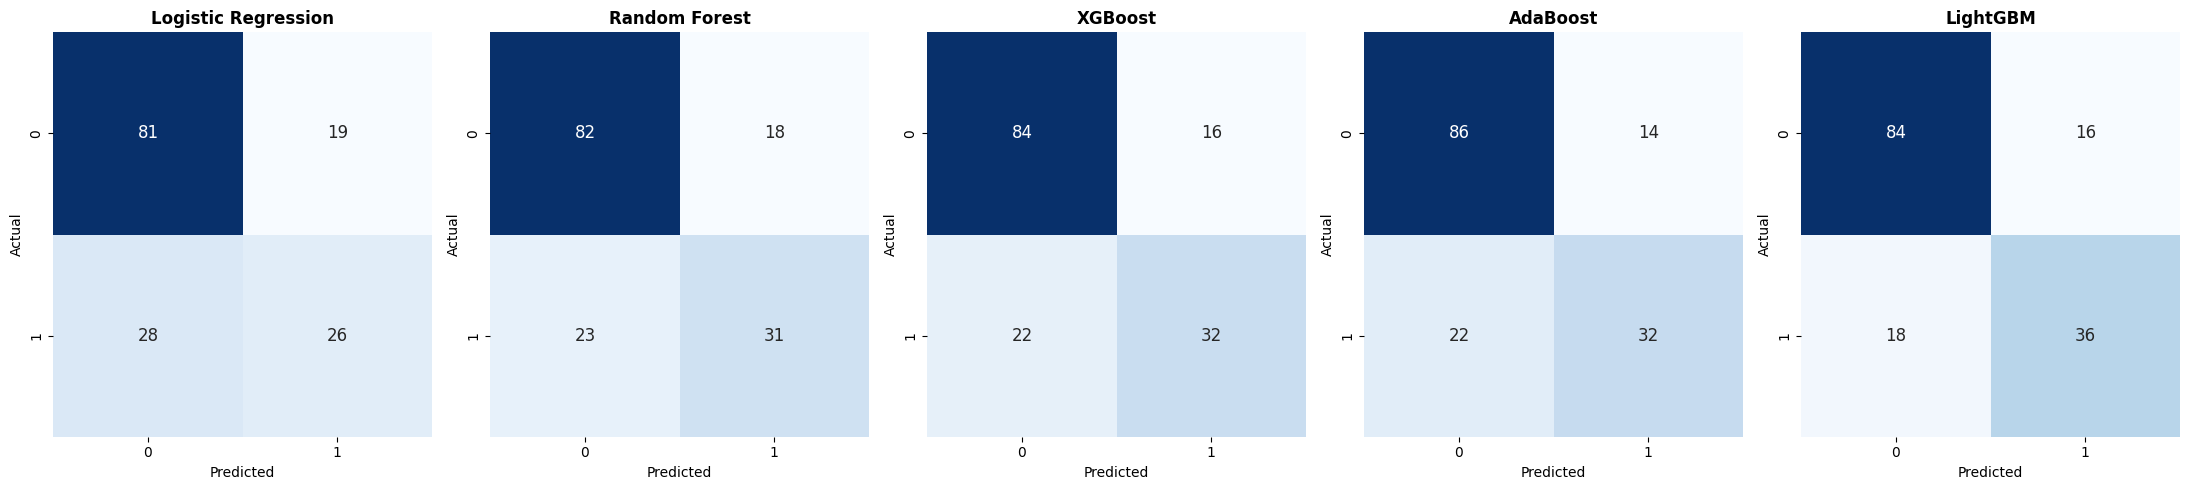

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrices
cm_log = confusion_matrix(y_test, y_pred_log)
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
cm_ada = confusion_matrix(y_test, y_pred_ada)
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)

cms = [cm_log, cm_rf, cm_xgb, cm_ada, cm_lgbm]
titles = ["Logistic Regression", "Random Forest", "XGBoost", "AdaBoost", "LightGBM"]

# Plot
fig, axes = plt.subplots(1, 5, figsize=(22, 5))

for ax, cm, title in zip(axes, cms, titles):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax,
                annot_kws={"size": 12})  # larger font
    ax.set_title(title, fontsize=12, fontweight="bold")
    ax.set_xlabel("Predicted", fontsize=10)
    ax.set_ylabel("Actual", fontsize=10)

plt.tight_layout()
plt.show()

**ROC Curves & AUC**

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


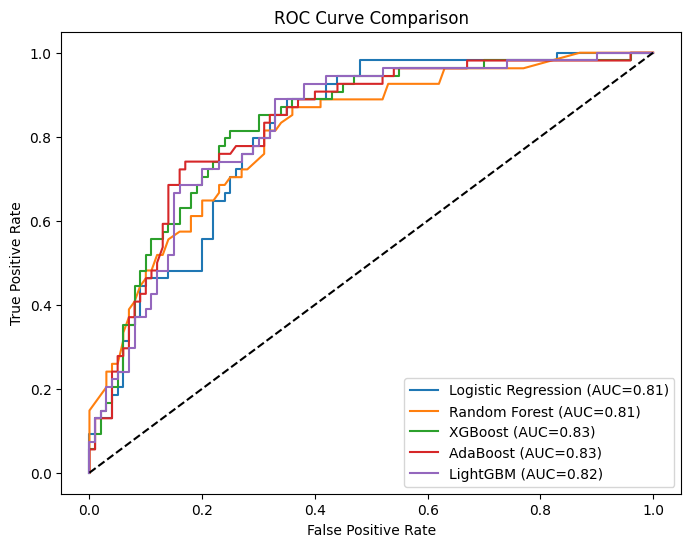

In [113]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Probabilities (needed for ROC curve)
y_prob_log  = log_reg.predict_proba(X_test_scaled)[:, 1]
y_prob_rf   = rf.predict_proba(X_test)[:, 1]
y_prob_xgb  = xgb.predict_proba(X_test)[:, 1]
y_prob_ada  = ada.predict_proba(X_test)[:, 1]
y_prob_lgbm = lgbm.predict_proba(X_test)[:, 1]

# ROC values
fpr_log, tpr_log, _   = roc_curve(y_test, y_prob_log)
fpr_rf, tpr_rf, _     = roc_curve(y_test, y_prob_rf)
fpr_xgb, tpr_xgb, _   = roc_curve(y_test, y_prob_xgb)
fpr_ada, tpr_ada, _   = roc_curve(y_test, y_prob_ada)
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_prob_lgbm)

# AUC scores
auc_log  = roc_auc_score(y_test, y_prob_log)
auc_rf   = roc_auc_score(y_test, y_prob_rf)
auc_xgb  = roc_auc_score(y_test, y_prob_xgb)
auc_ada  = roc_auc_score(y_test, y_prob_ada)
auc_lgbm = roc_auc_score(y_test, y_prob_lgbm)

# Plot ROC curves
plt.figure(figsize=(8,6))
plt.plot(fpr_log,  tpr_log,  label=f"Logistic Regression (AUC={auc_log:.2f})")
plt.plot(fpr_rf,   tpr_rf,   label=f"Random Forest (AUC={auc_rf:.2f})")
plt.plot(fpr_xgb,  tpr_xgb,  label=f"XGBoost (AUC={auc_xgb:.2f})")
plt.plot(fpr_ada,  tpr_ada,  label=f"AdaBoost (AUC={auc_ada:.2f})")
plt.plot(fpr_lgbm, tpr_lgbm, label=f"LightGBM (AUC={auc_lgbm:.2f})")

# Reference line (random guessing)
plt.plot([0,1], [0,1], 'k--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

**Feature Importance**

/tmp/ipython-input-2040020823.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances_rf.sort_values(ascending=False),


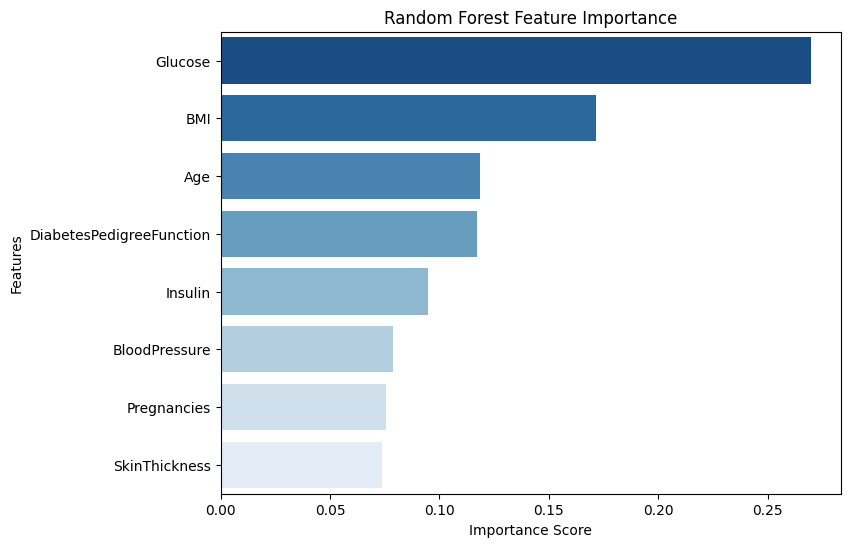

In [114]:
importances_rf = pd.Series(rf.feature_importances_, index=X.columns)

plt.figure(figsize=(8,6))
sns.barplot(x=importances_rf.sort_values(ascending=False),
            y=importances_rf.sort_values(ascending=False).index,
            palette="Blues_r")
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()


/tmp/ipython-input-1095849870.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances_xgb.sort_values(ascending=False),


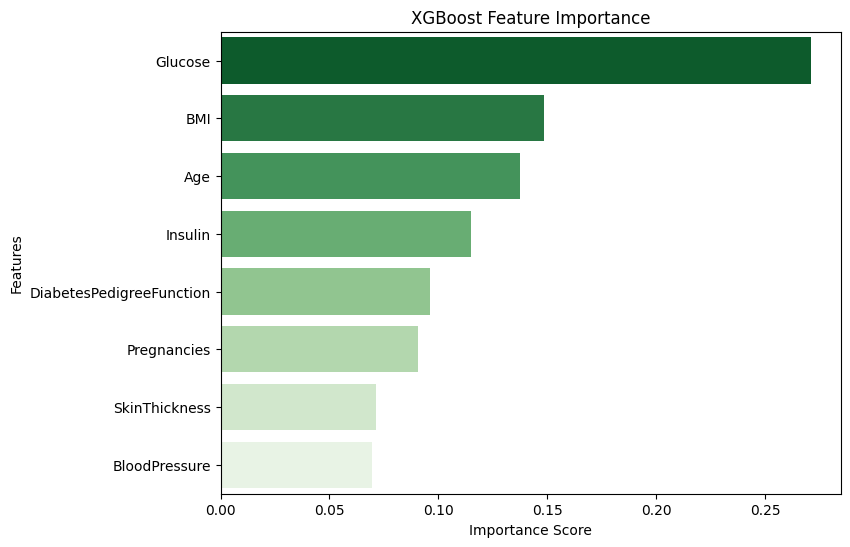

In [115]:
importances_xgb = pd.Series(xgb.feature_importances_, index=X.columns)

plt.figure(figsize=(8,6))
sns.barplot(x=importances_xgb.sort_values(ascending=False),
            y=importances_xgb.sort_values(ascending=False).index,
            palette="Greens_r")
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()


## **Saving and Loading the Model**

In [116]:
import joblib

joblib.dump(lgbm, "diabetes_lgbm_model.pkl")

['diabetes_lgbm_model.pkl']

- joblib is a Python library for saving and loading Python objects (like ML models). It works better than pickle for large models (like Random Forest or XGBoost).

- joblib.dump(xgb, "diabetes_xgb_model.pkl"): xgb is the trained XGBoost model.

This creates a file that contains all the trained parameters (trees, weights, etc.).

We are doing this to retrain the model every time we want to make predictions. we can just load it from disk later.

**Loading the Model Later**

In [117]:
import joblib
import pandas as pd

model = joblib.load("diabetes_lgbm_model.pkl")

FEATURES = [
    "Pregnancies", "Glucose", "BloodPressure", "SkinThickness",
    "Insulin", "BMI", "DiabetesPedigree", "Age"
]

def predict_diabetes(patient_data, threshold=0.5):
    """
    Predict diabetes status with LightGBM (clean, no warnings).
    patient_data: list of 8 values in order of FEATURES
    threshold: probability cutoff (default=0.5)
    Returns: pred (0/1), prob (float)
    """
    sample = pd.DataFrame([patient_data], columns=FEATURES)
    prob = model.predict_proba(sample)[0][1]
    pred = int(prob >= threshold)
    return pred, prob

In [118]:
sample = [2, 120, 70, 25, 80, 30.5, 0.5, 35]
pred, prob = predict_diabetes(sample)

print("Prediction:", pred)
print("Probability:", round(prob, 2))

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
Prediction: 0
Probability: 0.27
